[![Binder](https://mybinder.org/badge_logo.svg)](https://nbviewer.org/github/Sistemas-Multimedia/Sistemas-Multimedia.github.io/blob/master/milestones/07-DCT/block_DCT_compression.ipynb)

# Plot the RD curve using Block-DCT and PNG

## Parameters

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import os
import pylab
import cv2
import image_3
import image_1
import block_DCT
import YCoCg as YUV
!ln -sf ~/quantization/information.py .
import information
!ln -sf ~/quantization/distortion.py .
import distortion
!ln -sf ~/quantization/deadzone_quantizer.py .
import deadzone_quantizer as Q

In [2]:
image_1 = "/tmp/original_"
image_2 = "/tmp/original_prediction_error_"

In [3]:
block_y_side = block_x_side = 16

In [4]:
N_components = 3

In [5]:
entropy_estimator = "PNG"
# entropy_estimator = "entropy"
if entropy_estimator == "PNG":
    def compute_BPP(_image, filename_prefix):
        BPP = image_3.write(_image, filename_prefix, 0)*8/_image.size
        return BPP
else:
    def compute_BPP(_image, filename_prefix=''):
        entropy = information.entropy(_image.flatten().astype(np.int16))
        return entropy

In [6]:
Q_steps = [128, 64, 32, 16, 8] #, 4, 2, 1]

In [7]:
img = image_3.read(image_2, 2)
YUV_img = YUV.from_RGB(img.astype(np.int16))
avgs = [np.average(YUV_img[..., c]) for c in range(3)]
print(f"avgs={avgs}")
for c in range(3):
    YUV_img[..., c] -= int(avgs[c])
RD_points_1 = []
for Q_step in Q_steps:
    DCT_blocks = block_DCT.analyze_image(YUV_img, block_y_side, block_x_side)
    # Notice that with uniform_quantize() does not matter if the DCT domain
    # is organized in subbands or blocks.
    DCT_blocks_k = block_DCT.uniform_quantize(DCT_blocks, block_y_side, block_x_side, N_components, Q_step)
    #BPP = image_3.write((DCT_blocks_k + 128).astype(np.uint8), f"/tmp/{Q_step}_", 0)*8/YUV_img.size
    DCT_blocks_dQ = block_DCT.uniform_dequantize(DCT_blocks_k, block_y_side, block_x_side, N_components, Q_step)
    YUV_img_dQ = block_DCT.synthesize_image(DCT_blocks_dQ, block_y_side, block_x_side)
    for c in range(3):
        YUV_img_dQ[..., c] += int(avgs[c])
    img_dQ = YUV.to_RGB(YUV_img_dQ)
    # Notice that to compute the distortion, the DCT domain could be
    # also used because the DCT is unitary.
    RMSE = distortion.RMSE(img, img_dQ)
    #RD_points_blocks.append((BPP, RMSE))
    DCT_subbands_k = block_DCT.get_subbands(DCT_blocks_k, block_y_side, block_x_side)
    BPP = compute_BPP((DCT_subbands_k + 128).astype(np.uint8), f"/tmp/{Q_step}_")
    RD_points_1.append((BPP, RMSE))
    print(f"Q_step={Q_step} BPP={BPP} image-domain-RMSE={RMSE}")

image_3.read: /tmp/original_prediction_error_002.png (288, 352, 3) uint8 127081 176 94 
avgs=[127.70823469065657, 0.20915206755050506, -0.1493252840909091]
image_3.write: /tmp/128_000.png (288, 352, 3) uint8 107 128 128 
Q_step=128 BPP=0.0028146043771043773 image-domain-RMSE=3.1386580739977683
image_3.write: /tmp/64_000.png (288, 352, 3) uint8 107 128 128 
Q_step=64 BPP=0.0028146043771043773 image-domain-RMSE=3.1386580739977683
image_3.write: /tmp/32_000.png (288, 352, 3) uint8 107 128 128 
Q_step=32 BPP=0.0028146043771043773 image-domain-RMSE=3.1386580739977683


** Processing: /tmp/128_000.png
352x288 pixels, 3x8 bits/pixel, RGB
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 685 bytes
Input file size = 742 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 35
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 35
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 35
  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 35
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 35
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 35

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 35

Output IDAT size = 35 bytes (650 bytes decrease)
Output file size = 107 bytes (635 bytes = 85.58% decrease)

** Processing: /tmp/64_000.png
352x288 pixels, 3x8 bits/pixel, RGB
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 685 bytes
Input file size = 742 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 35
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 35
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 35
  zc = 9  zm = 8  zs =

image_3.write: /tmp/16_000.png (288, 352, 3) uint8 412 129 127 
Q_step=16 BPP=0.010837542087542087 image-domain-RMSE=3.0413585616057386
image_3.write: /tmp/8_000.png (288, 352, 3) uint8 3015 131 126 
Q_step=8 BPP=0.07930871212121213 image-domain-RMSE=2.9213076352317464


** Processing: /tmp/8_000.png
352x288 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 44 colors in palette
Input IDAT size = 5015 bytes
Input file size = 5072 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 2823
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 2814
                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 2814

Output IDAT size = 2814 bytes (2201 bytes decrease)
Output file size = 3015 bytes (2057 bytes = 40.56% decrease)



In [8]:
img = image_3.read(image_2, 3)
YUV_img = YUV.from_RGB(img.astype(np.int16))
avgs = [np.average(YUV_img[..., c]) for c in range(3)]
print(f"avgs={avgs}")
for c in range(3):
    YUV_img[..., c] -= int(avgs[c])
RD_points_2 = []
for Q_step in Q_steps:
    DCT_blocks = block_DCT.analyze_image(YUV_img, block_y_side, block_x_side)
    # Notice that with uniform_quantize() does not matter if the DCT domain
    # is organized in subbands or blocks.
    DCT_blocks_k = block_DCT.uniform_quantize(DCT_blocks, block_y_side, block_x_side, N_components, Q_step)
    #BPP = image_3.write((DCT_blocks_k + 128).astype(np.uint8), f"/tmp/{Q_step}_", 0)*8/YUV_img.size
    DCT_blocks_dQ = block_DCT.uniform_dequantize(DCT_blocks_k, block_y_side, block_x_side, N_components, Q_step)
    YUV_img_dQ = block_DCT.synthesize_image(DCT_blocks_dQ, block_y_side, block_x_side)
    for c in range(3):
        YUV_img_dQ[..., c] += int(avgs[c])
    img_dQ = YUV.to_RGB(YUV_img_dQ)
    # Notice that to compute the distortion, the DCT domain could be
    # also used because the DCT is unitary.
    RMSE = distortion.RMSE(img, img_dQ)
    #RD_points_blocks.append((BPP, RMSE))
    DCT_subbands_k = block_DCT.get_subbands(DCT_blocks_k, block_y_side, block_x_side)
    BPP = compute_BPP((DCT_subbands_k + 128).astype(np.uint8), f"/tmp/{Q_step}_")
    RD_points_2.append((BPP, RMSE))
    print(f"Q_step={Q_step} BPP={BPP} image-domain-RMSE={RMSE}")

image_3.read: /tmp/original_prediction_error_003.png (288, 352, 3) uint8 127379 173 97 
avgs=[127.71698429608585, 0.1979659880050505, -0.12938959911616163]


** Processing: /tmp/128_000.png
352x288 pixels, 3x8 bits/pixel, RGB
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 685 bytes
Input file size = 742 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 35
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 35
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 35
  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 35
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 35
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 35

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 35

Output IDAT size = 35 bytes (650 bytes decrease)
Output file size = 107 bytes (635 bytes = 85.58% decrease)



image_3.write: /tmp/128_000.png (288, 352, 3) uint8 107 128 128 
Q_step=128 BPP=0.0028146043771043773 image-domain-RMSE=3.078976113552731
image_3.write: /tmp/64_000.png (288, 352, 3) uint8 107 128 128 
Q_step=64 BPP=0.0028146043771043773 image-domain-RMSE=3.078976113552731
image_3.write: /tmp/32_000.png (288, 352, 3) uint8 113 129 128 
Q_step=32 BPP=0.00297243265993266 image-domain-RMSE=3.0764419728872


** Processing: /tmp/64_000.png
352x288 pixels, 3x8 bits/pixel, RGB
Reducing image to 1 bit/pixel, 1 color in palette
Input IDAT size = 685 bytes
Input file size = 742 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 35
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 35
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 35
  zc = 9  zm = 8  zs = 0  f = 5		IDAT size = 35
  zc = 9  zm = 8  zs = 1  f = 5		IDAT size = 35
  zc = 9  zm = 8  zs = 3  f = 5		IDAT size = 35

Selecting parameters:
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 35

Output IDAT size = 35 bytes (650 bytes decrease)
Output file size = 107 bytes (635 bytes = 85.58% decrease)

** Processing: /tmp/32_000.png
352x288 pixels, 3x8 bits/pixel, RGB
Reducing image to 1 bit/pixel, 2 colors in palette
Input IDAT size = 692 bytes
Input file size = 749 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 40
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 40
  zc = 9  zm = 8  zs = 3  f = 0		IDAT size = 38
  zc = 9  zm = 8  zs =

image_3.write: /tmp/16_000.png (288, 352, 3) uint8 402 130 127 
Q_step=16 BPP=0.01057449494949495 image-domain-RMSE=2.98412144484083


** Processing: /tmp/8_000.png
352x288 pixels, 3x8 bits/pixel, RGB
Reducing image to 8 bits/pixel, 41 colors in palette
Input IDAT size = 4239 bytes
Input file size = 4296 bytes

Trying:
  zc = 9  zm = 8  zs = 0  f = 0		IDAT size = 2386
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 2385
  zc = 1  zm = 8  zs = 2  f = 0

image_3.write: /tmp/8_000.png (288, 352, 3) uint8 2577 132 126 
Q_step=8 BPP=0.06778724747474747 image-domain-RMSE=2.9041459926731057


                               
Selecting parameters:
  zc = 9  zm = 8  zs = 1  f = 0		IDAT size = 2385

Output IDAT size = 2385 bytes (1854 bytes decrease)
Output file size = 2577 bytes (1719 bytes = 40.01% decrease)



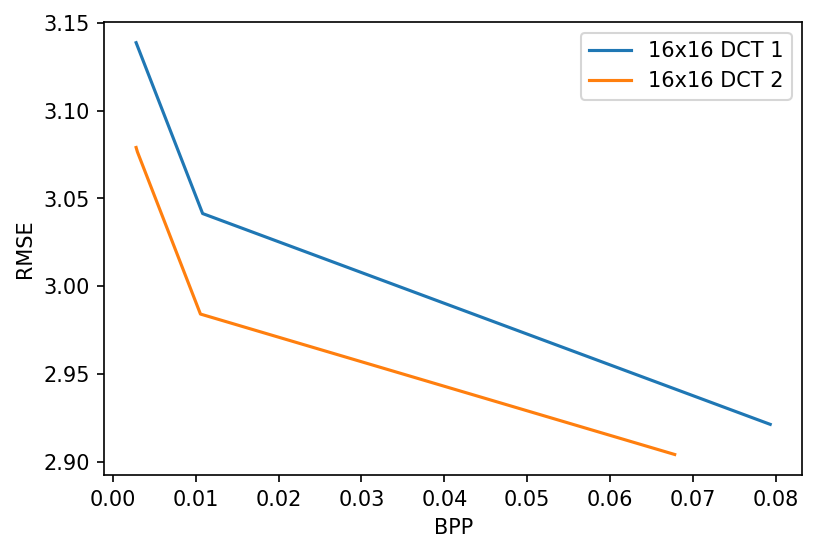

In [9]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RD_points_1), label=f"{block_y_side}x{block_x_side} DCT 1")
pylab.plot(*zip(*RD_points_2), label=f"{block_y_side}x{block_x_side} DCT 2")
pylab.title("")
pylab.xlabel("BPP")
pylab.ylabel("RMSE")
plt.legend(loc="best")
pylab.show()